In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split ,Dataset
import torchvision.transforms as T
from torchvision.utils import make_grid
import os
from PIL import Image

# Data Preparation

In [2]:
#Loan metadata
data_csv = pd.read_csv('../input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv')
data_csv = data_csv.rename(columns = {'Unnamed: 0':'Index'}) #rename index column

In [3]:
print(data_csv.isnull().sum())
data_csv.head()


Index                        0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5841
Label_1_Virus_category    1576
dtype: int64


,Index,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
#Create a new category Label Subcat where we recode the categories as Normal, Pneumonia Viral, Pneumonia Bacterial, or Pneumonia Stress.
#We do not model for COVID 19 since we only have a few datasets for COVID.

data_csv.loc[data_csv['Label'] == 'Normal', 'Label_Subcat'] = 'Normal'
data_csv.loc[(data_csv['Label'] == 'Pnemonia') & (data_csv['Label_1_Virus_category']=='Virus'), 'Label_Subcat'] = 'Pneumonia'
data_csv.loc[(data_csv['Label'] == 'Pnemonia') & (data_csv['Label_1_Virus_category']=='bacteria'), 'Label_Subcat'] = 'Pneumonia'
data_csv.loc[(data_csv['Label'] == 'Pnemonia') & (data_csv['Label_1_Virus_category']=='Stress-Smoking'), 'Label_Subcat'] = 'Pneumonia' 


In [5]:
data_csv['Label_Subcat'].value_counts()

Pneumonia    4334
Normal       1576
Name: Label_Subcat, dtype: int64

In [6]:
data_csv.head()

,Index,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,Label_Subcat
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN,Normal
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN,Normal
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN,Normal
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN,Normal
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN,Normal


In [7]:
# This dictionary is used to convert named labels into encoders as 0 ,1 ,2 and 3 that can be understood by the model
name_dict={'Normal':0,
           'Pneumonia':1}
def encode_label(img_label):
    return name_dict[img_label]

In [8]:
#This dictionary is used to get label names from numerical encoders
label_dict={0:'Normal',
            1:'Pneumonia'}

In [9]:
#Create the directory for train and test sets

dir_train = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
dir_test = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'

#Filter dataset to train and test
train_filtered = data_csv[data_csv['Dataset_type']=='TRAIN']
test_filtered = data_csv[data_csv['Dataset_type']=='TEST']


In [10]:
#This class is used to load data
class XrayDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['X_ray_image_name'], row['Label_Subcat']
        img_fname = self.root_dir + "/" + str(img_id)
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

In [11]:
train_tfms = T.Compose([
    T.Resize(32),   # to resize images
    T.CenterCrop(32),
    T.Grayscale(num_output_channels=1), # to convert all images into 1 channel
    T.ToTensor() # to convert images into tensors 
])
valid_tfms = T.Compose([T.Resize(32),
                        T.CenterCrop(32),
                        T.Grayscale(num_output_channels=1),
                        T.ToTensor()])

In [12]:
#Dividing data into training and validation sets
np.random.seed(28)
msk = np.random.rand(len(train_filtered)) < 0.9

train_df = train_filtered[msk].reset_index()
val_df = train_filtered[~msk].reset_index()


In [13]:
train_ds = XrayDataset(train_df, dir_train, transform=train_tfms)
val_ds = XrayDataset(val_df,dir_train, transform=valid_tfms)
len(train_ds), len(val_ds)

(4750, 536)

Normal


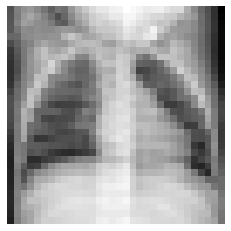

In [14]:
#view one sample image from training data
x,y=train_ds[3]
print(label_dict[y])
plt.axis("off")
plt.imshow(x[0,:,:],cmap='gray');


Pneumonia


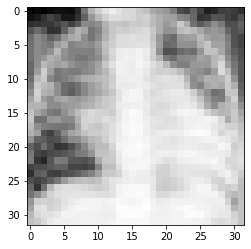

In [15]:
#view one sample image from validation data
x,y=val_ds[450]
plt.imshow(x[0,:,:],cmap='gray')
print(label_dict[y])

# Training and Validation loader

In [16]:
batch_size = 64

train_loader = DataLoader(train_ds, batch_size, shuffle=True,num_workers=3,pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2,num_workers=3,pin_memory=True)

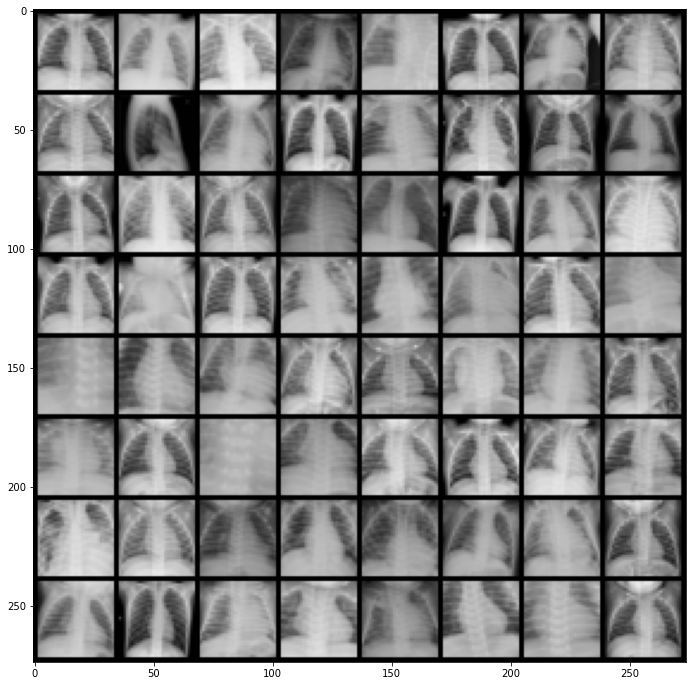

In [17]:
#View one batch of validation loader
for xb,yb in train_loader:
    plt.figure(figsize=(12,12))
    plt.imshow(make_grid(xb).permute(1,2,0))
    break

# Moving To GPU:

Since we are using networks which contains large number of matrice multiplication,thus it's importatnt to use GPU's for this purpose which reduces time of computation

In [18]:
#this functtion is used to check the default device 
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

#this function moves data and model to preferable device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device=get_default_device()
device

device(type='cuda')

# Logistic Regression Model

In [20]:
input_size=1024  #1*32*32
output_size=2

In [26]:
def accuracy(outputs,labels): #this function is used to check accuracy of model
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

class LogisticModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 1024)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    


In [27]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [28]:
logi_model = to_device(LogisticModel(), device)
logi_model

LogisticModel(
  (linear): Linear(in_features=1024, out_features=2, bias=True)
)

In [30]:
%%time
history_1 = fit(5, 0.001, logi_model, train_loader, val_loader)

Epoch [0], val_loss: 0.4852, val_acc: 0.7859
Epoch [1], val_loss: 0.4576, val_acc: 0.7859
Epoch [2], val_loss: 0.4446, val_acc: 0.7891
Epoch [3], val_loss: 0.4255, val_acc: 0.8031
Epoch [4], val_loss: 0.4052, val_acc: 0.8078
CPU times: user 1.1 s, sys: 1 s, total: 2.11 s
Wall time: 8min 48s


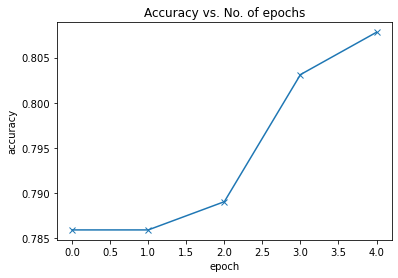

In [146]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    
plot_accuracies(history_1)

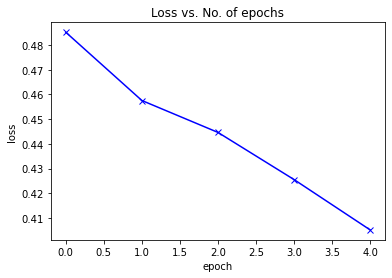

In [148]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(val_losses, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')

plot_losses(history_1)

# Testing Model on Testset

In [31]:
test_filtered.reset_index(inplace=True) # to reset index of test columns
test_filtered.head()

,index,Index,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,Label_Subcat
0,5286,5309,IM-0021-0001.jpeg,Normal,TEST,NaN,NaN,Normal
1,5287,5310,IM-0019-0001.jpeg,Normal,TEST,NaN,NaN,Normal
2,5288,5311,IM-0017-0001.jpeg,Normal,TEST,NaN,NaN,Normal
3,5289,5312,IM-0016-0001.jpeg,Normal,TEST,NaN,NaN,Normal
4,5290,5313,IM-0015-0001.jpeg,Normal,TEST,NaN,NaN,Normal


In [32]:
test_data = XrayDataset(test_filtered,dir_test , transform=valid_tfms)
len(test_data)

624

In [35]:
logi_result = evaluate(logi_model, test_loader)
logi_result

{'val_loss': 0.6171552538871765, 'val_acc': 0.637499988079071}

**We get test accuracy around 64% by simple Neural Logistic Regression Model**

# CNN Model


In [36]:
def accuracy(outputs,labels): #this function is used to check accuracy of model
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

class cnnBase(nn.Module):
    def training_step(self,batch):
        xb,labels=batch
        out=self(xb)
        loss=F.cross_entropy(out,labels)
        return loss
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [67]:
class CnnModel(cnnBase):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
                     nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
                     nn.ReLU(),
                     nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
                     nn.ReLU(),
                     nn.MaxPool2d(2,2), #64*16*16
            
                     nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                     nn.ReLU(),
                     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                     nn.ReLU(),
                     nn.MaxPool2d(2,2), # output: 128*8*8

                     nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                     nn.ReLU(),
                     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                     nn.ReLU(),
                     nn.MaxPool2d(2,2), # output: 256*4*4

                     nn.Flatten(), 
                     nn.Linear(256*4*4, 1024),
                     nn.ReLU(),
                     nn.Linear(1024, 512),
                     nn.ReLU(),
                     nn.Linear(512, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [68]:
@torch.no_grad()
def evaluate(model, val_loader): #This function is used to evaluate validation set
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [69]:
Cnn_model = to_device(CnnModel(), device)
Cnn_model

CnnModel(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features=512, b

In [70]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [71]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 0.001

In [72]:
%%time
Cnn_history = fit(num_epochs, lr, Cnn_model, train_loader, val_loader, opt_func)


Epoch [0], train_loss: 0.5728, val_loss: 0.3334, val_acc: 0.8266
Epoch [1], train_loss: 0.3402, val_loss: 0.1613, val_acc: 0.9448
Epoch [2], train_loss: 0.1722, val_loss: 0.1852, val_acc: 0.9266
Epoch [3], train_loss: 0.1681, val_loss: 0.0868, val_acc: 0.9635
Epoch [4], train_loss: 0.1394, val_loss: 0.1122, val_acc: 0.9599
Epoch [5], train_loss: 0.1186, val_loss: 0.0961, val_acc: 0.9635
Epoch [6], train_loss: 0.1188, val_loss: 0.0620, val_acc: 0.9812
Epoch [7], train_loss: 0.0946, val_loss: 0.0736, val_acc: 0.9682
CPU times: user 5.57 s, sys: 1.92 s, total: 7.49 s
Wall time: 14min 52s


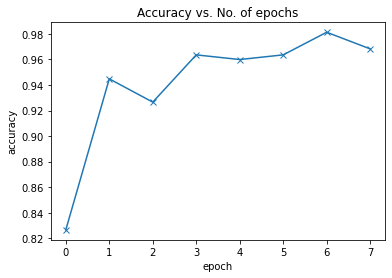

In [73]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    
plot_accuracies(Cnn_history)

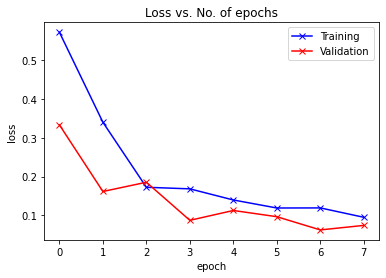

In [74]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

plot_losses(Cnn_history)

In [33]:
#Function to predict individual test image
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return label_dict[preds[0].item()]

Label: Normal , Predicted: Normal


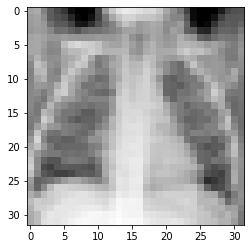

In [75]:
img, label = test_data[113]
plt.imshow(img[0,:,:],cmap='gray')
print('Label:', label_dict[label], ', Predicted:', predict_image(img, Cnn_model))

Label: Pneumonia , Predicted: Pneumonia


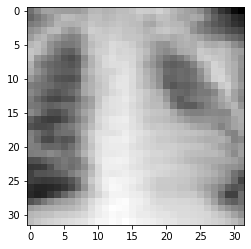

In [76]:
img, label = test_data[321]
plt.imshow(img[0,:,:],cmap='gray')
print('Label:', label_dict[label], ', Predicted:', predict_image(img, Cnn_model))

Label: Normal , Predicted: Pneumonia


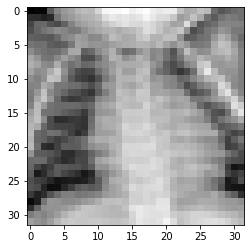

In [77]:
img, label = test_data[121]
plt.imshow(img[0,:,:],cmap='gray')
print('Label:', label_dict[label], ', Predicted:', predict_image(img, Cnn_model))

In [34]:
test_loader = DeviceDataLoader(DataLoader(test_data, batch_size,num_workers=3,pin_memory=True),device)

In [78]:
Cnn_result = evaluate(Cnn_model, test_loader)
Cnn_result

{'val_loss': 0.8154700398445129, 'val_acc': 0.8020833134651184}

We get Test accuracy around 80%

# ResNet Model

Now we use are using ResNet model to classify images

In [126]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ResNetBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_loss'], result['val_loss'], result['val_acc']))

In [127]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ResNetBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64) 
        self.conv2 = conv_block(64, 128, pool=True)# 128*16*16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True) # 256*8*8
        self.conv4 = conv_block(256, 512, pool=True) # 512*4*4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [128]:
#Training the Model
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit_one_cycle(epochs, lr, model, train_loader, val_loader, 
                  opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [138]:
model = to_device(ResNet(1, 2), device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

In [139]:
epochs = 4
lr = 0.001
opt_func = torch.optim.Adam

In [140]:
%%time
history_resnet = fit_one_cycle(epochs, lr, model, train_loader, val_loader,  
                             opt_func=opt_func)

Epoch [0],train_loss: 0.2581, val_loss: 0.5027, val_acc: 0.8313
Epoch [1],train_loss: 0.1054, val_loss: 0.3982, val_acc: 0.8568
Epoch [2],train_loss: 0.0919, val_loss: 0.0574, val_acc: 0.9797
Epoch [3],train_loss: 0.0815, val_loss: 0.1529, val_acc: 0.9427
CPU times: user 4.31 s, sys: 1 s, total: 5.31 s
Wall time: 7min 19s


In [141]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')


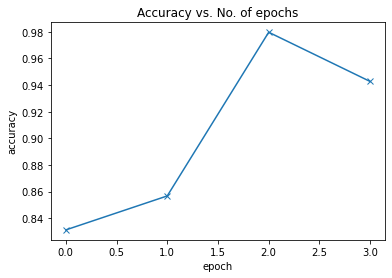

In [142]:
plot_accuracies(history_resnet)

In [143]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

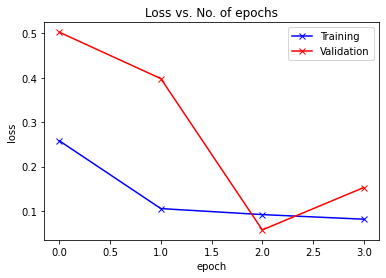

In [144]:
plot_losses(history_resnet)

In [122]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return label_dict[preds[0].item()]

Label: Pneumonia , Predicted: Pneumonia


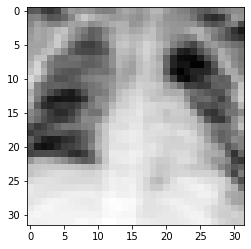

In [149]:
img, label = test_data[323]
plt.imshow(img[0,:,:],cmap='gray')
print('Label:', label_dict[label], ', Predicted:', predict_image(img, resnet_model))

In [145]:
result_resnet = evaluate(model, test_loader)
result_resnet

{'val_loss': 0.6871234774589539, 'val_acc': 0.8187500238418579}

We get Test accuracy around 82% with just 4 epochs of model.This accuracy can still be improved while doing further iterations

While performing modelling with ResNet9 you can make some bunch of improvements in fit function and model architecture that boosts up accuracies:
1. Batch Normalization
2. Learning rate Scheduling
3. Weight decay
4. Gradient Clipping
5. Adam optimizer